### Filters applied 

- **Start year ≥ 2000** – drop any trial that began before 1 Jan 2000  
- **Enrolment ≥ 10 participants** – exclude studies that planned or enrolled fewer than 10 subjects *or* have missing enrolment information  
- **Duration ≤ 10 years** – remove trials whose actual duration exceeds 3 650 days  
- **Completion date is in the past** – keep only records with a non-null primary/overall completion date that is **≤ today**  
- **Completion type = ACTUAL & status ∈ {Completed, Terminated}** – discard trials that report only an *anticipated* finish date or are still recruiting/suspended


In [15]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
df = pd.read_parquet("../data/processed/features_v1.parquet")
df.head()

,indication/disease area,"rare, non-rare (established disease area and clear diagnosis criteria)","mode of administration (ex. NBE, NCE, iv vs pill)",disease modifying or treating symptoms,population - adults vs peds,phase,# patients,primary_outcomes,secondary_outcomes,other_outcomes,...,condition_top,intervention_type,start_year,country_n,site_n,assessments_n,assessments_complexity,screen fail rate,evaluability / drop out rate,safety events
0,Infertility,"[{'abbrev': 'BXS', 'name': 'Urinary Tract, Sex...",DRUG,TREATMENT,[ADULT],Phase 4,28.0,"[{'description': None, 'measure': 'Number of o...","[{'description': None, 'measure': 'Number of e...",None,...,Infertility,DRUG,2015.0,0,0,0,Low,NaN,NaN,NaN
1,Pompe Disease,"[{'abbrev': 'BC10', 'name': 'Nervous System Di...",DRUG,TREATMENT,"[ADULT, OLDER_ADULT]",Phase 2,25.0,[{'description': 'A TEAE was defined as an adv...,[{'description': 'The total GAA activity in sk...,None,...,Pompe Disease,DRUG,2011.0,0,0,0,Low,NaN,NaN,NaN
3,Internet-Based Intervention,"[{'abbrev': 'BXM', 'name': 'Behaviors and Ment...",OTHER,TREATMENT,"[ADULT, OLDER_ADULT]",Unknown,697.0,[{'description': 'Change in the 16-item Malada...,[{'description': 'Change in the Brief Symptom ...,[{'description': 'Change in the Mindful Attent...,...,Internet-Based Intervention,OTHER,2018.0,0,0,0,Low,NaN,NaN,NaN
4,Cancer,"[{'abbrev': 'BC04', 'name': 'Neoplasms'}, {'ab...",DRUG,TREATMENT,"[ADULT, OLDER_ADULT]",Phase 1,23.0,[{'description': 'Blood samples will be collec...,[{'description': 'Blood samples will be collec...,None,...,Cancer,DRUG,2013.0,0,0,0,Low,NaN,NaN,NaN
6,Malignant Pleural Effusion,"[{'abbrev': 'BC08', 'name': 'Respiratory Tract...",DRUG,TREATMENT,"[ADULT, OLDER_ADULT]",Phase 3,60.0,[{'description': 'Success of treatment defined...,[{'description': 'Observing amount of pleural ...,None,...,Malignant Pleural Effusion,DRUG,2015.0,0,0,0,Low,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 281548 entries, 0 to 538872
Data columns (total 42 columns):
 #   Column                                                                                           Non-Null Count   Dtype         
---  ------                                                                                           --------------   -----         
 0   indication/disease area                                                                          281548 non-null  object        
 1   rare, non-rare (established disease area and clear diagnosis criteria)                           242807 non-null  object        
 2   mode of administration (ex. NBE, NCE, iv vs pill)                                                257335 non-null  object        
 3   disease modifying or treating symptoms                                                           218664 non-null  object        
 4   population - adults vs peds                                                     

None

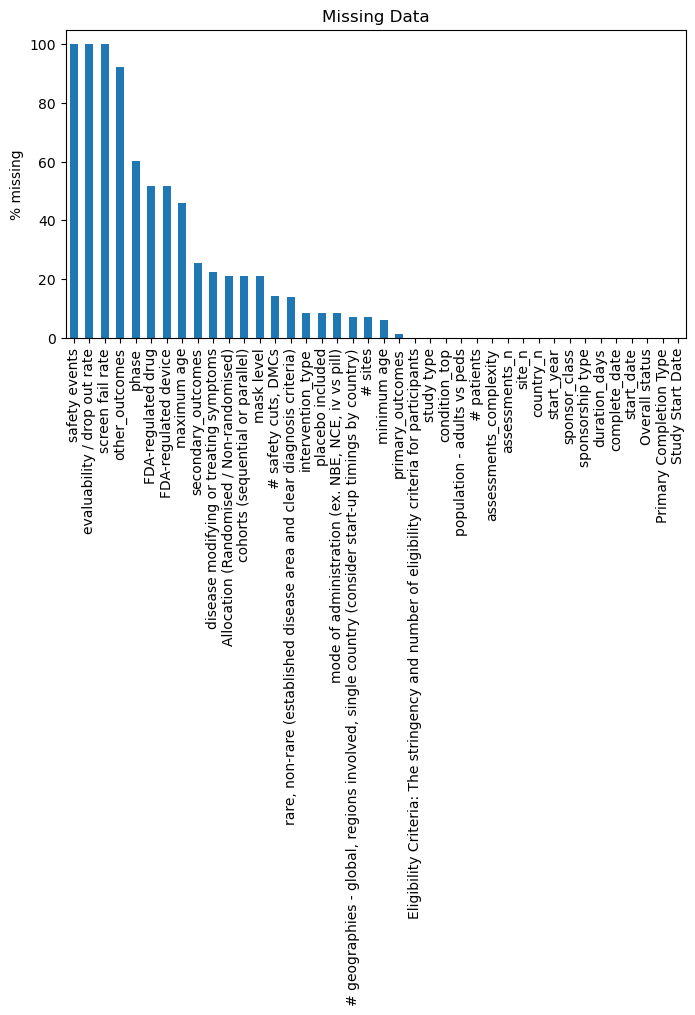

,missing_rows,pct_missing
evaluability / drop out rate,281548,100.000000
safety events,281548,100.000000
screen fail rate,281548,100.000000
other_outcomes,259475,92.160129
phase,169441,60.181923
FDA-regulated drug,145789,51.781224
FDA-regulated device,145765,51.772700
maximum age,129171,45.878855
secondary_outcomes,71345,25.340262
disease modifying or treating symptoms,62884,22.335090


In [16]:
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# Make a temporary copy where phase=="Unknown" is NaN
tmp = df.copy()
if "phase" in tmp.columns:
    tmp.loc[tmp["phase"] == "Unknown", "phase"] = pd.NA   # or np.nan


# Standard DataFrame info with counts
display(tmp.info(show_counts=True))

# Missing-percentage bar plot
miss = tmp.isna().mean().sort_values(ascending=False) * 100
miss.head(40).plot.bar(figsize=(8,4))
plt.ylabel("% missing")
plt.title("Missing Data")
plt.show()

# Table with absolute & % missing
miss_tbl = pd.DataFrame({
    "missing_rows": tmp.isna().sum(),
    "pct_missing":  miss
}).sort_values("pct_missing", ascending=False)

display(miss_tbl.head(40)) # show top-40 variables


## Trials per Phase


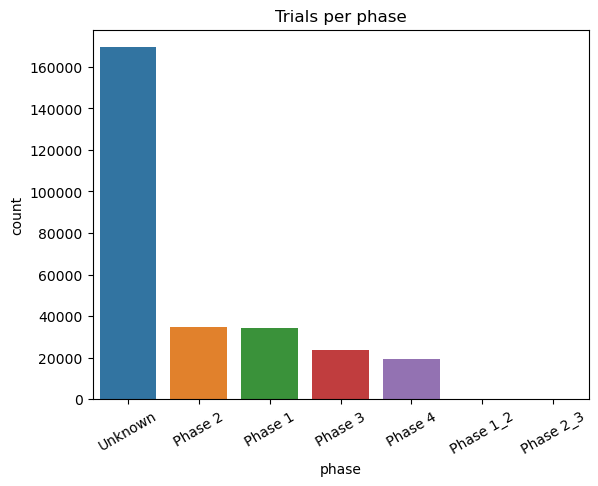

In [17]:
sns.countplot(data=df, x="phase", order=df["phase"].value_counts().index)
plt.xticks(rotation=30); plt.title("Trials per phase"); plt.show()

## Duration by phase 

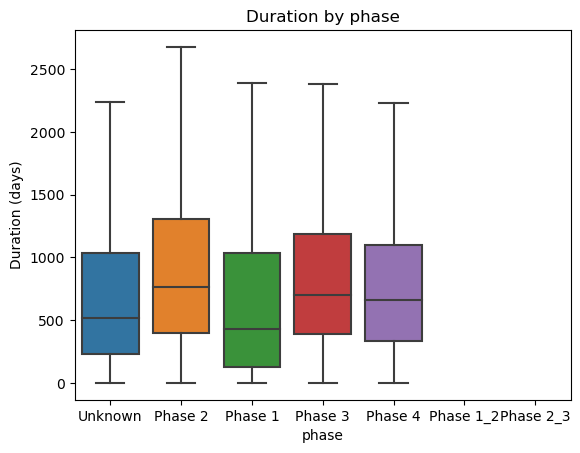

In [18]:
sns.boxplot(data=df, x="phase", y="duration_days",
            order=df["phase"].value_counts().index, showfliers=False)
plt.ylabel("Duration (days)"); plt.title("Duration by phase"); plt.show()

## Duration by Phase and Sponsor Class


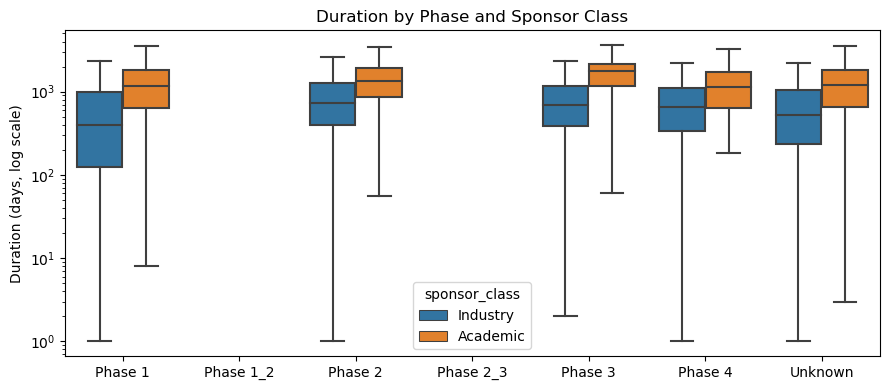

In [19]:
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x="phase", y="duration_days",
            hue="sponsor_class", showfliers=False,
            order=["Phase 1","Phase 1_2","Phase 2","Phase 2_3","Phase 3","Phase 4","Unknown"])
plt.yscale("log")
plt.title("Duration by Phase and Sponsor Class")
plt.ylabel("Duration (days, log scale)")
plt.xlabel("")
plt.tight_layout(); plt.show()


## Trial Duration by Start Year 


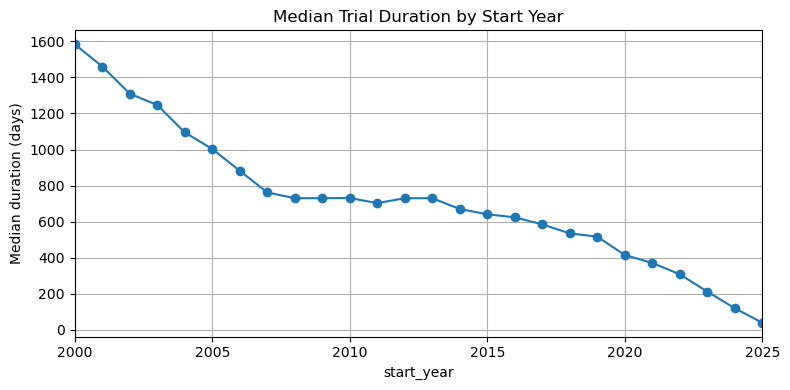

In [51]:
# keep only trials between 1980 and 2025
lower_year = 2000
cutoff_year = 2025
# Filter rows whose start_year is in the desired interval
mask = (df["start_year"] >= lower_year) & (df["start_year"] <= cutoff_year)
df_plot = df[mask]

# Plot median duration by start year
ax = (df_plot.groupby("start_year")["duration_days"]
          .median()
          .plot(marker="o", figsize=(8, 4)))

ax.set_ylabel("Median duration (days)")
ax.set_title("Median Trial Duration by Start Year")
ax.set_xlim(lower_year, cutoff_year)   # keep the x-axis tight to the interval
ax.grid(True)
plt.tight_layout()
plt.show()


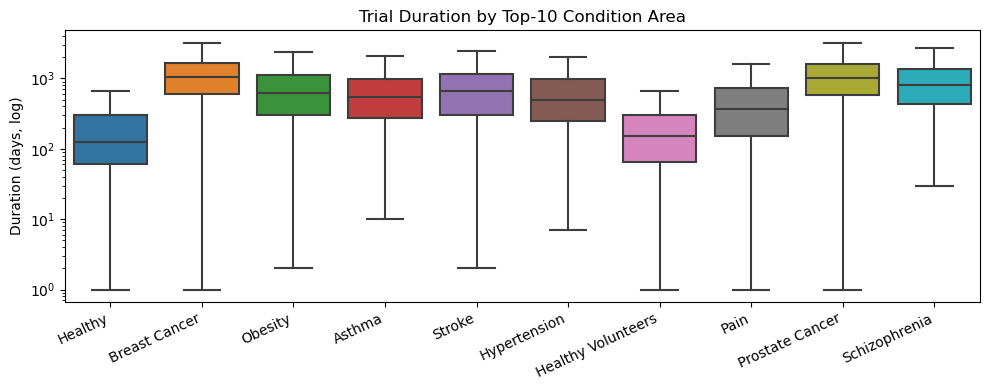

In [21]:
top10 = df["condition_top"].value_counts().index[:10]
sub   = df[df["condition_top"].isin(top10)]

plt.figure(figsize=(10,4))
sns.boxplot(data=sub, x="condition_top", y="duration_days",
            showfliers=False,
            order=top10)
plt.yscale("log")
plt.xticks(rotation=25, ha="right"); plt.xlabel("")
plt.ylabel("Duration (days, log)")
plt.title("Trial Duration by Top-10 Condition Area")
plt.tight_layout(); plt.show()


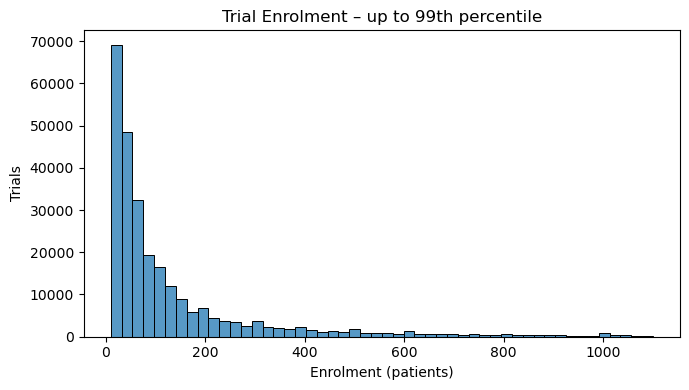

Trials above the cap: 14042


In [38]:
cap = np.percentile(df["# patients"].dropna(), 95)    # ≈ 99th-percentile
trunc = df[df["# patients"] <= cap]["# patients"]

plt.figure(figsize=(7,4))
sns.histplot(trunc, bins=50, kde=False)
plt.xlabel("Enrolment (patients)")
plt.ylabel("Trials")
plt.title("Trial Enrolment – up to 99th percentile")
plt.tight_layout(); plt.show()

print("Trials above the cap:", (df["# patients"] > cap).sum())


In [40]:
import pandas as pd
import numpy as np
from IPython.display import display

# ---- descriptive statistics -----------------------------------
desc = df["# patients"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_frame()
desc.rename(columns={"# patients": "patients"}, inplace=True)  # nicer header
desc.loc["variance"] = df["# patients"].var()
desc.loc["std dev"]  = df["# patients"].std()

# round large integers for readability
desc = desc.applymap(lambda x: f"{int(x):,}" if pd.notna(x) else x)

print("Enrolment – descriptive statistics")
display(desc)

# ---- summary of extreme tail -----------------------------------
cap = np.percentile(df["# patients"].dropna(), 99)
above_cap = df[df["# patients"] > cap].shape[0]

print(f"\n99th-percentile (cap) : {cap:,.0f} patients")
print(f"Trials above cap      : {above_cap:,}")


Enrolment – descriptive statistics


,patients
count,"281,548"
mean,"3,937"
std,"407,304"
min,10
1%,10
5%,14
25%,32
50%,68
75%,180
95%,"1,100"



99th-percentile (cap) : 8,708 patients
Trials above cap      : 2,816


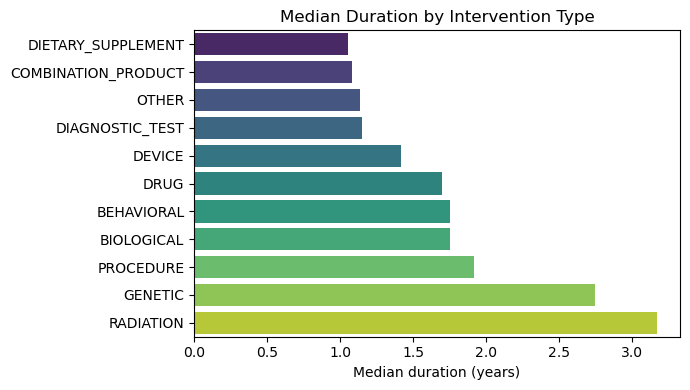

In [30]:
# count top N types
topn = df["intervention_type"].value_counts().head(12).index
sub  = df[df["intervention_type"].isin(topn)]

pivot = (sub.groupby("intervention_type")
              ["duration_days"].median()
              .sort_values())            # ascending for nicer y-axis

plt.figure(figsize=(7,4))
sns.barplot(x=pivot.values/365.25,   # convert to years
            y=pivot.index, palette="viridis")
plt.xlabel("Median duration (years)"); plt.ylabel("")
plt.title("Median Duration by Intervention Type")
plt.tight_layout(); plt.show()


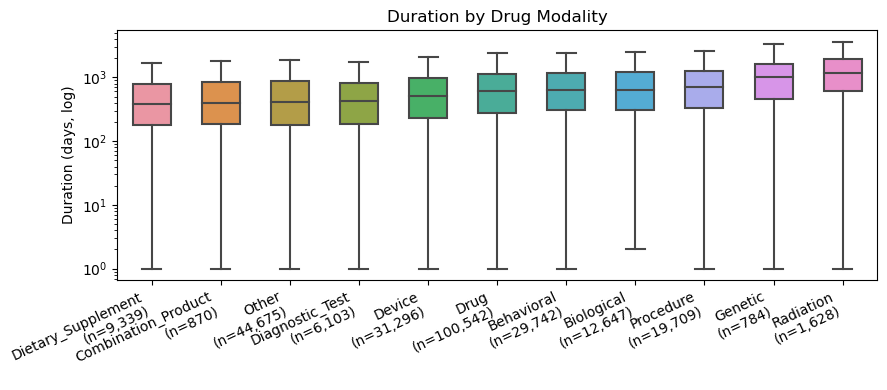

In [33]:
# order modalities by median duration (years for intuition)
median_days = df.groupby("drug_modality")["duration_days"].median().sort_values()
order = median_days.index

plt.figure(figsize=(9,4))
sns.boxplot(
    data=df, x="drug_modality", y="duration_days",
    order=order, showfliers=False, width=0.55
)
plt.yscale("log")
plt.ylabel("Duration (days, log)")
plt.xlabel("")
plt.title("Duration by Drug Modality")

# add n per category on x-tick labels
ticks = [f"{m}\n(n={df[df['drug_modality']==m].shape[0]:,})" for m in order]
plt.xticks(range(len(order)), ticks, rotation=25, ha="right")
plt.tight_layout(); plt.show()


In [55]:
print("Drug modalities array:")
print(df["drug_modality"].dropna().unique())

print("\nInterventions array:")
print(df["intervention_type"].dropna().unique())


Drug modalities array:
['Drug' 'Other' 'Device' 'Behavioral' 'Dietary_Supplement'
 'Diagnostic_Test' 'Procedure' 'Biological' 'Radiation'
 'Combination_Product' 'Genetic']

Interventions array:
['DRUG' 'OTHER' 'DEVICE' 'BEHAVIORAL' 'DIETARY_SUPPLEMENT'
 'DIAGNOSTIC_TEST' 'PROCEDURE' 'BIOLOGICAL' 'RADIATION'
 'COMBINATION_PRODUCT' 'GENETIC']
